## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


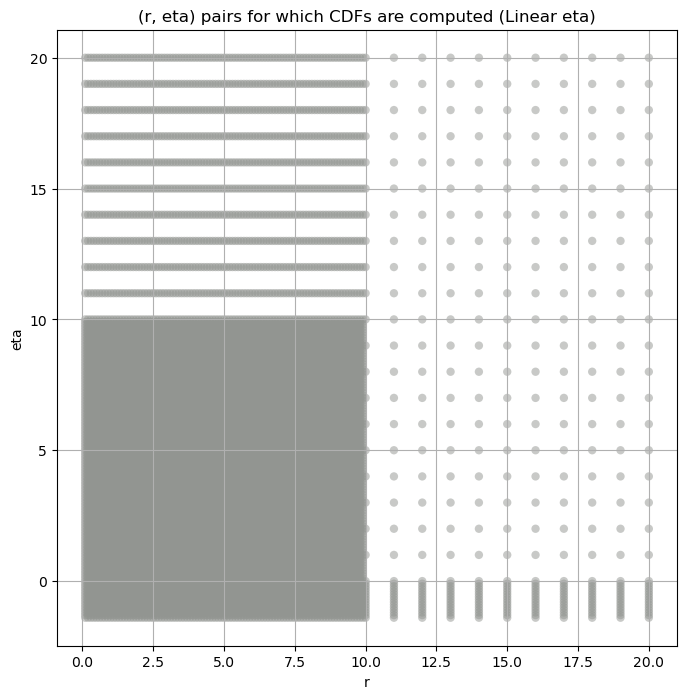

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      150198.140000  85009.770000  248359.050000   411.54047   85.167190   
3       33515.440000  19958.848000   52689.242000   366.28464  101.323944   
4        8690.679000   4650.463400   15441.654000   584.81180  124.459560   
5        1600.978300    772.027800    3722.795000  1309.71000   95.391490   
6         339.471440    152.138280    1059.495200  2686.09840   93.139860   
7          87.097680     35.839172     371.944120  4825.42970   72.401490   
8          29.885605     15.551421      79.539055  1686.66770   80.563995   
9           8.939856      4.773542      23.292429  1590.28990   83.618610   
10          1.352918      0.687688       4.300090  2542.24950   78.125960   

       kurt_upper  total_samples  
layer                             
2       581.20276           9000  
3       561.97730          36000  
4      1337.51990         144000  
5      3193.55200         576000  
6      4761.97360        2304000  
7      6356.89800        9216000  
8      3720.50220       36864000  
9      3577.24000      147456000  
10     4648.80300      589824000

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      150198.140000  150198.140625    49061.003906    41599.644531   
3       33515.440000   33515.441406    15847.681641    13293.618164   
4        8690.679000    8690.678711     4907.688477     3975.857666   
5        1600.978300    1600.978271      811.826843      681.377991   
6         339.471440     339.471436      160.047836      134.269424   
7          87.097680      87.097679       37.291824       31.925552   
8          29.885605      29.885605       16.272236       13.734270   
9           8.939856       8.939856        4.999969        4.207000   
10          1.352918       1.352918        0.726434        0.617232   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        36892.714844     33270.269531     27887.826172     23950.017578   
3        11865.467773     10862.390625      9495.165039      8534.375977   
4         3506.434082      3187.639160      2776.307861      2505.122314   
5          606.292053       556.370422       488.207214       441.746735   
6          119.535912       109.896690        97.363731        89.021172   
7           28.962181        26.966150        24.342495        22.607737   
8           12.378673        11.528172        10.488605         9.835453   
9            3.789239         3.527531         3.197263         2.981694   
10           0.557625         0.518800         0.468385         0.434936   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         20819.259766     18418.128906     16407.539062     12186.845703  
3          7792.362305      7185.180664      6685.328613      5581.003906  
4          2305.065186      2150.210938      2022.451050      1738.378540  
5           407.616394       380.672852       358.295349       309.207703  
6            82.758263        77.815132        73.771187        64.822029  
7            21.324377        20.312122        19.480980        17.637058  
8             9.357824         8.978533         8.661778         7.931565  
9             2.820768         2.691520         2.583104         2.332819  
10            0.409889         0.389799         0.372982         0.334370

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.023584325304125464 150198.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.012910606090310084 49061.004


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.014251007346054001 41599.645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.01590459528422894 36892.715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.01807016454564858 33270.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.023232380862080015 27887.826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.027382413413093443 23950.018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.03288788007356249 20819.26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.03809926110866684 18418.129


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.0428252806229652 16407.54


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.058801911690954944 12186.846
Number of samples: 9000, Without approximation : 9000


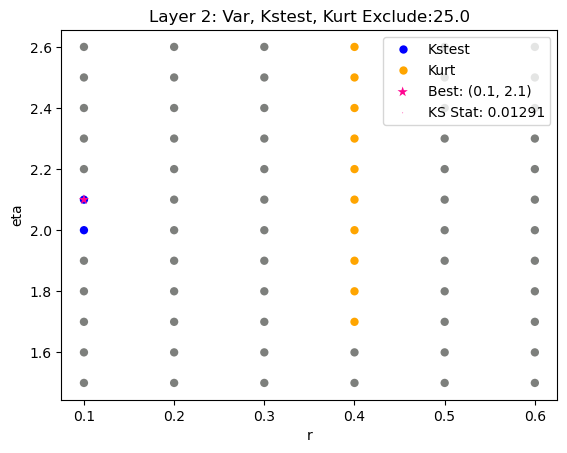

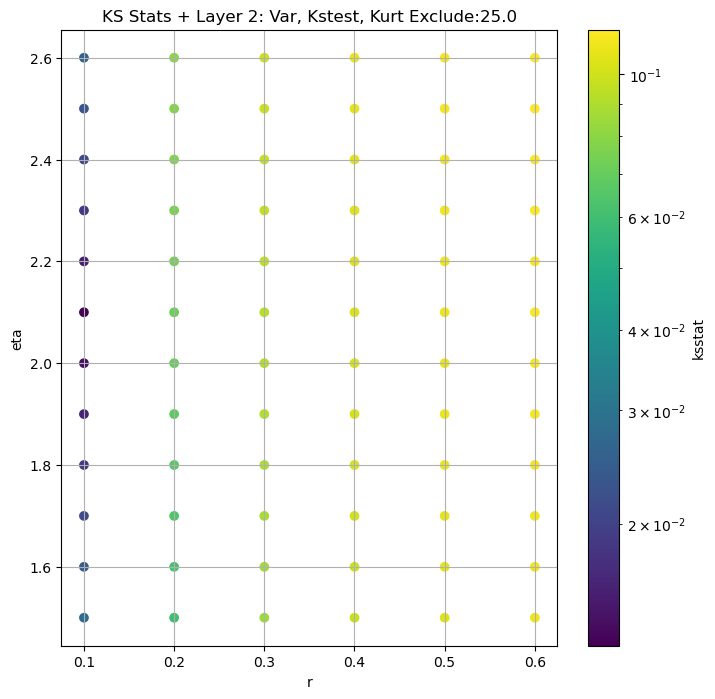

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.028713895161074032 33515.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.017700632969152252 15847.682


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.015452307837470786 13293.618


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.014310352132573922 11865.468


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.013173271221619626 10862.391


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.01178843358649928 9495.165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.011234063604816491 8534.376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.011926598862903814 7792.3623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.013076344305317344 7185.1807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.014879383920060385 6685.3286


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.018488748191163196 5581.004
Number of samples: 36000, Without approximation : 36000


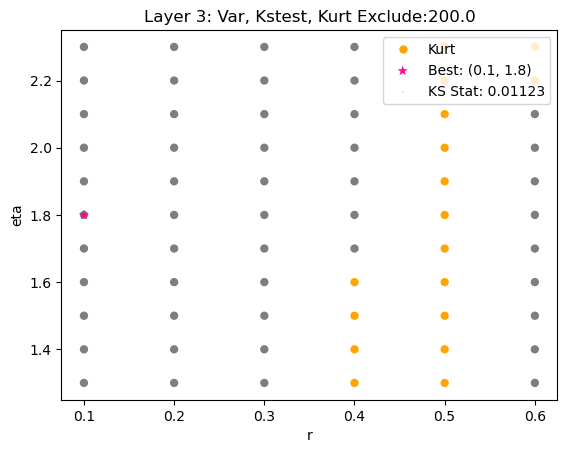

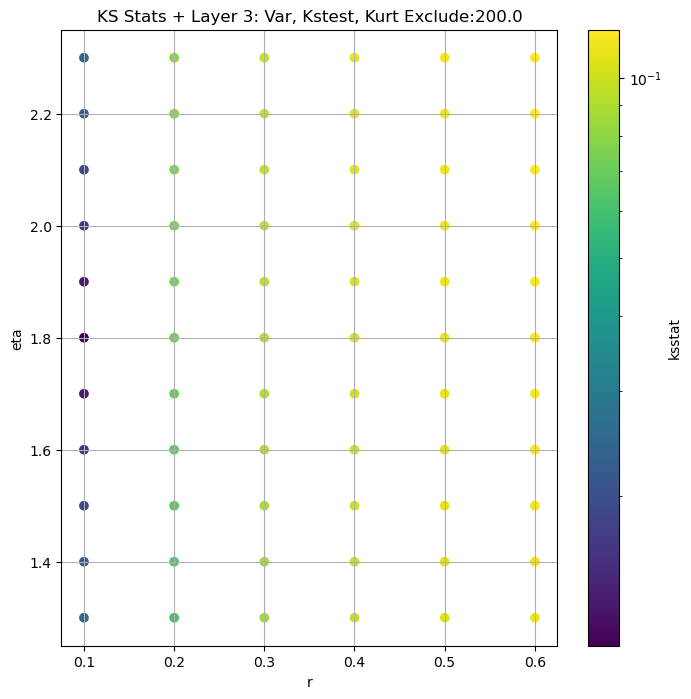

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03484729021638877 8690.679


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.025387180138781384 4907.6885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.020576680371985567 3975.8577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.01986319411968085 3506.434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.018379078512933633 3187.6392


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.014445828047444875 2776.3079


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.0140592305584325 2505.1223


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.011703522019795853 2305.0652


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.010130639041988632 2150.211


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.008972604035812015 2022.451


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.008803470986496201 1738.3785
Number of samples: 100000, Without approximation : 144000


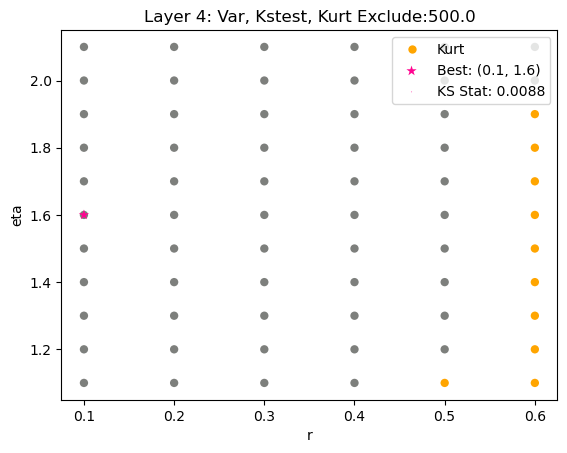

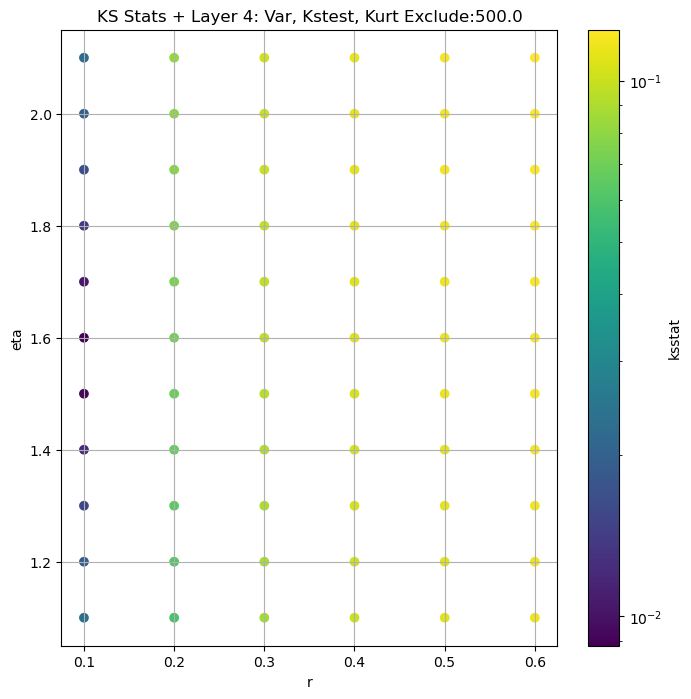

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03601265084296962 1600.9783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.02469465438316737 811.82684


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.02073621825515859 681.378


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.018072854268713953 606.29205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.015955281883620442 556.3704


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.013502872490962714 488.2072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.012335622628386278 441.74673


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.010350264905896578 407.6164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.009788268540235623 380.67285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00781791431589729 358.29535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008056728104868016 309.2077
Number of samples: 100000, Without approximation : 576000


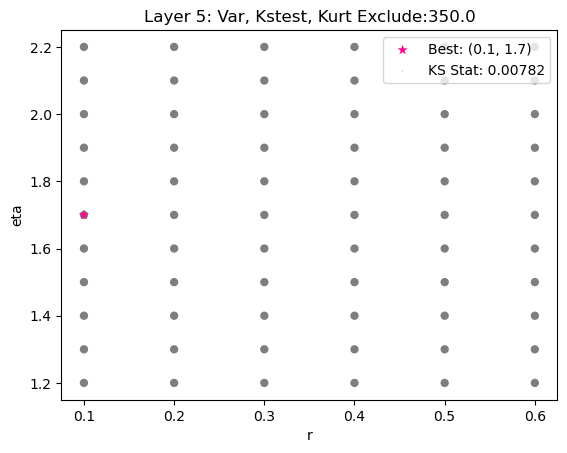

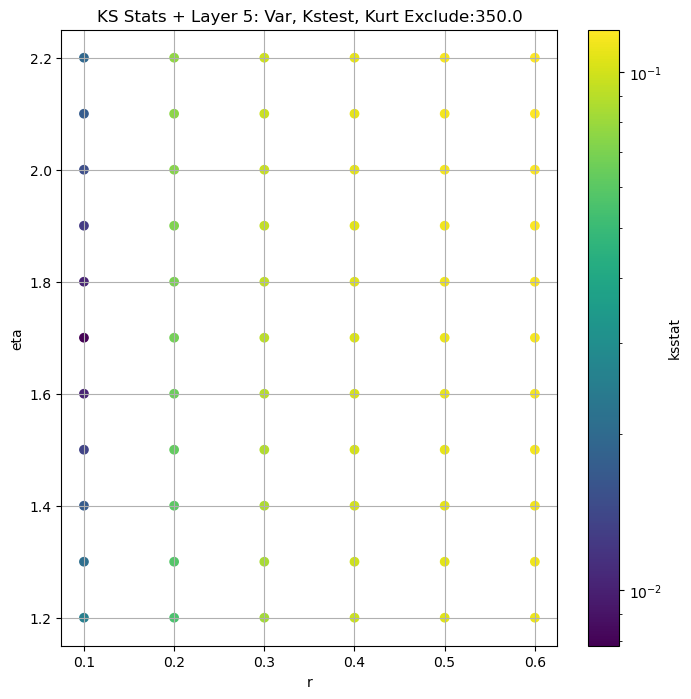

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.03486077491132241 339.47144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.02184857533238549 160.04784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.018472225828373934 134.26942


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.015453888666219884 119.53591


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.013871423397548432 109.89669


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.010987850617908412 97.36373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.008717002697313792 89.02117


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.007147495902528278 82.75826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.005392103284187044 77.81513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.005420890892775754 73.77119


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.007098650009839114 64.82203
Number of samples: 100000, Without approximation : 2304000


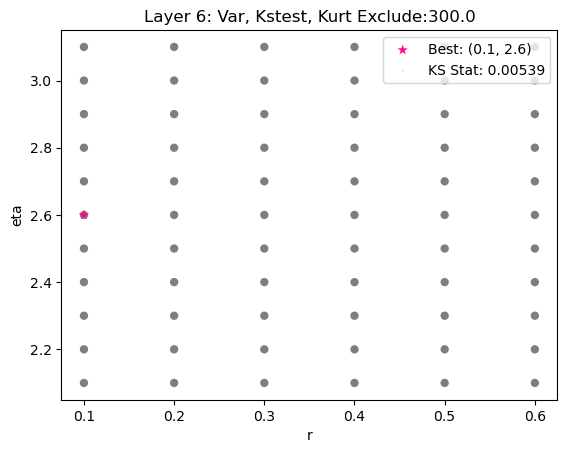

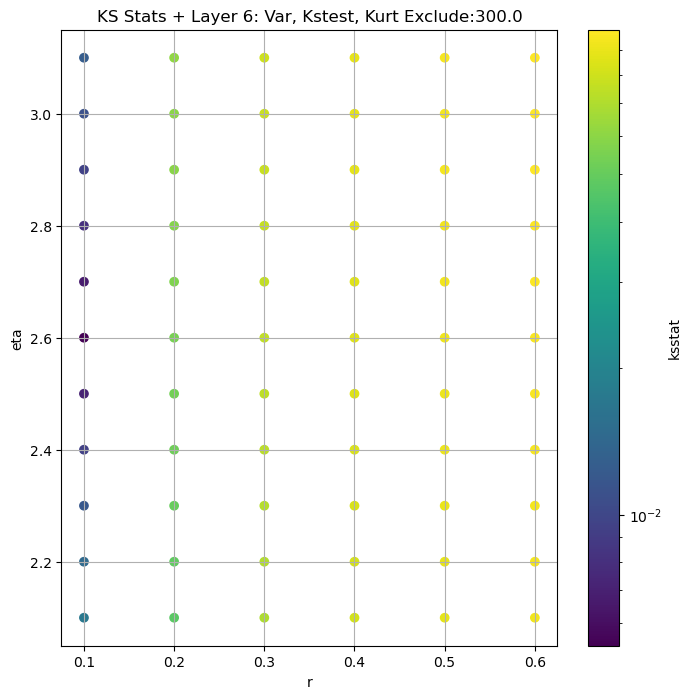

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.03323597924717654 87.09768


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.0158425234106071 37.291824


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.012204272493479662 31.925552


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.009809966091743227 28.962181


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.008409291755344994 26.96615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0054796835396213606 24.342495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0038841552121486878 22.607737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.0037430957850161928 21.324377


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.004354558422349886 20.312122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.004933264612590693 19.48098


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.006624472979929186 17.637058
Number of samples: 100000, Without approximation : 9216000


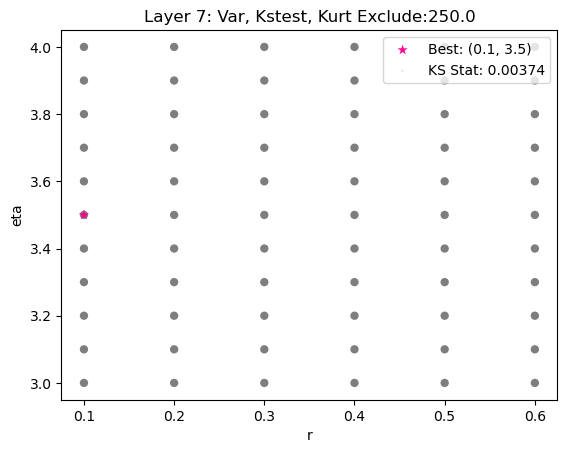

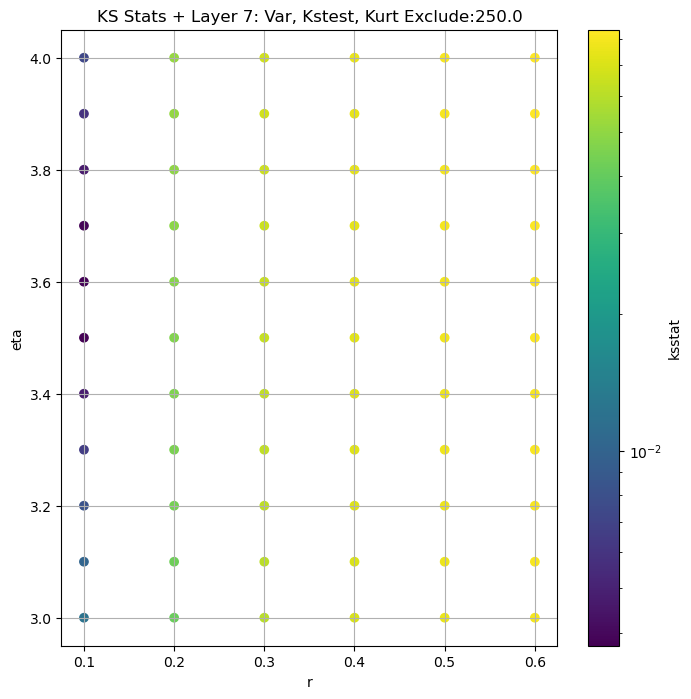

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.02463346400585765 29.885605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.011476781959504134 16.272236


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.007667530006043699 13.73427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.005298878784413097 12.378673


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0039867031424716814 11.528172


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.00219098969823317 10.488605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0031910133304334787 9.835453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0038290099812534617 9.357824


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.004470080873907323 8.978533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005186376152739536 8.661778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.007087566677838608 7.931565
Number of samples: 100000, Without approximation : 36864000


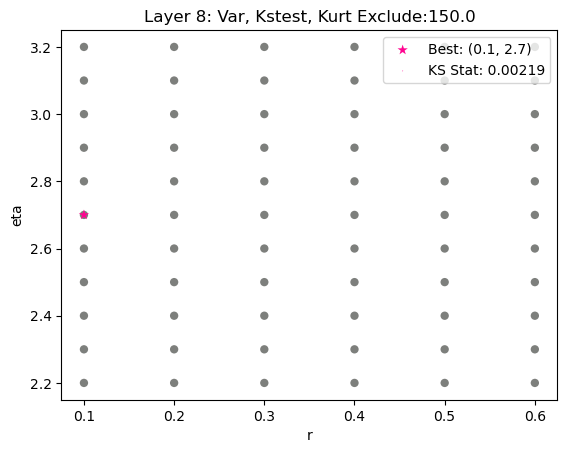

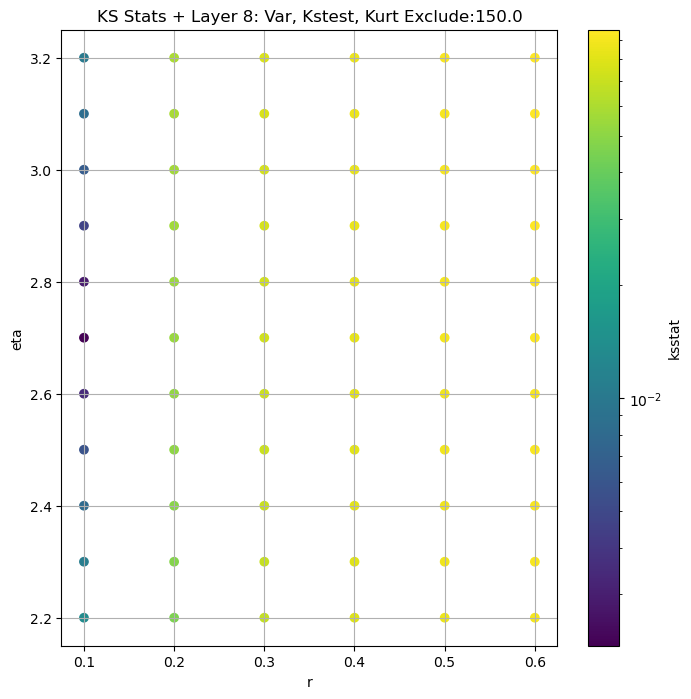

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.026171410072510615 8.939856


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.014613235996730423 4.9999685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.01124294972742007 4.207


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.009318022019367864 3.789239


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.007104157036992853 3.5275307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.005265050424244133 3.197263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.0038092322898495012 2.9816942


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.004753862998368004 2.8207679


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.005188205568636063 2.6915205


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.00573316899711554 2.5831041


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.00774533976226166 2.3328185
Number of samples: 100000, Without approximation : 147456000


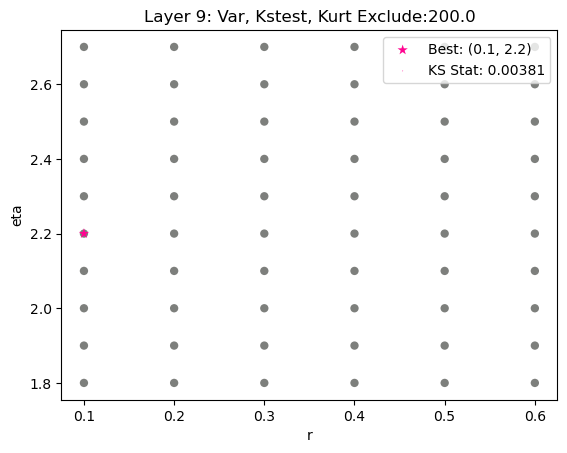

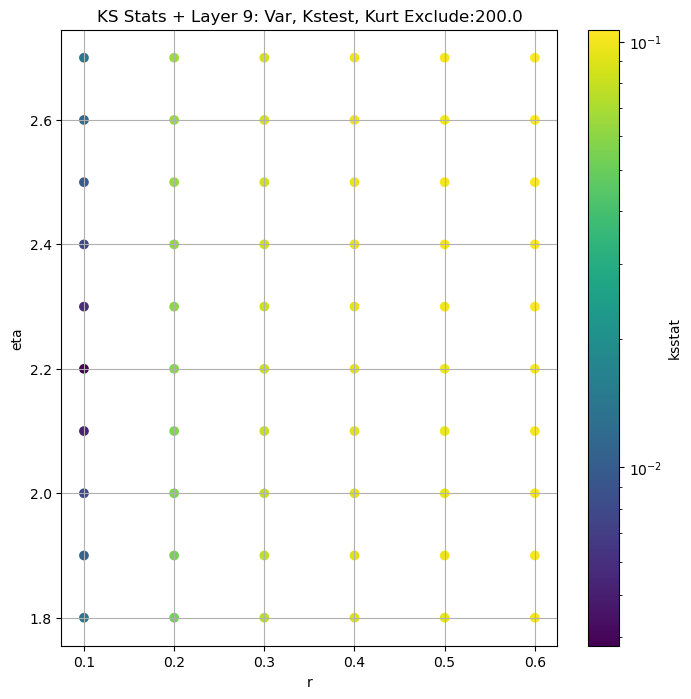

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.027834802668352365 1.3529184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.01601358632798243 0.7264338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.013880395099958684 0.61723167


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.011342069522992548 0.557625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.009581088053689499 0.51879984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.007116864587420224 0.46838453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.005766013157194688 0.43493587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.005432242186101666 0.40988937


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.0058120471612339575 0.3897988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.00657984572931869 0.37298217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.007989695004227776 0.33437037
Number of samples: 100000, Without approximation : 589824000


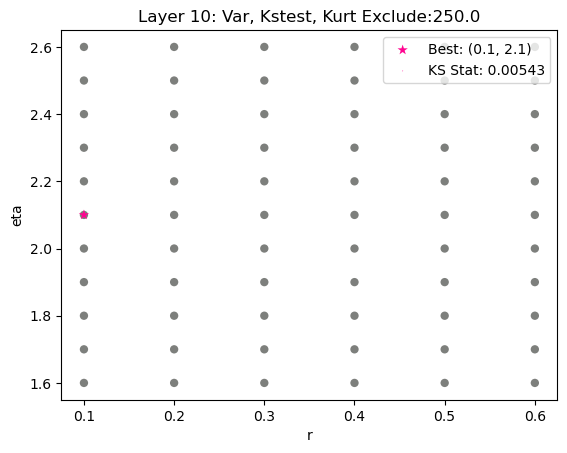

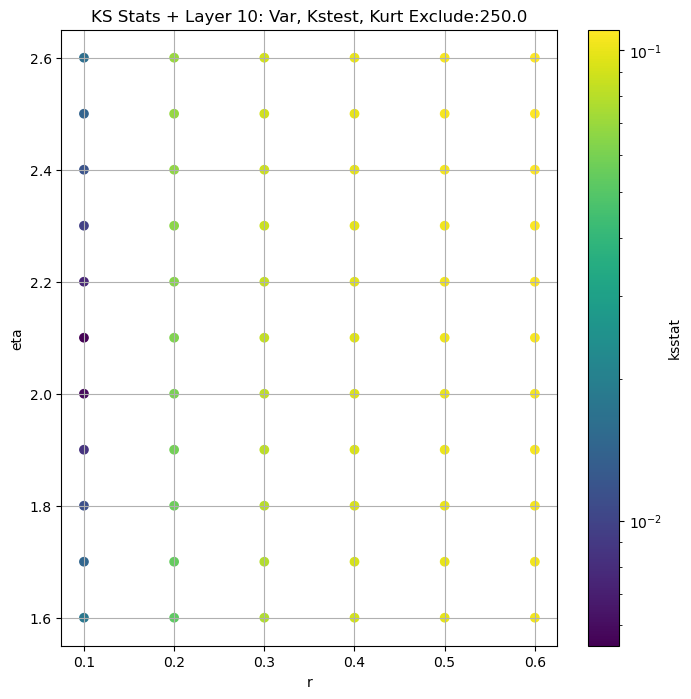

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      150198.140000  85009.770000  248359.050000   411.54047   85.167190   
3       33515.440000  19958.848000   52689.242000   366.28464  101.323944   
4        8690.679000   4650.463400   15441.654000   584.81180  124.459560   
5        1600.978300    772.027800    3722.795000  1309.71000   95.391490   
6         339.471440    152.138280    1059.495200  2686.09840   93.139860   
7          87.097680     35.839172     371.944120  4825.42970   72.401490   
8          29.885605     15.551421      79.539055  1686.66770   80.563995   
9           8.939856      4.773542      23.292429  1590.28990   83.618610   
10          1.352918      0.687688       4.300090  2542.24950   78.125960   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       581.20276           9000             0.012911        0.1          2.1   
3       561.97730          36000             0.011234        0.1          1.8   
4      1337.51990         144000             0.008803        0.1          1.6   
5      3193.55200         576000             0.007818        0.1          1.7   
6      4761.97360        2304000             0.005392        0.1          2.6   
7      6356.89800        9216000             0.003743        0.1          3.5   
8      3720.50220       36864000             0.002191        0.1          2.7   
9      3577.24000      147456000             0.003809        0.1          2.2   
10     4648.80300      589824000             0.005432        0.1          2.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.237964e-12                    25.0        49061.004000   
3       1.598326e-12                   200.0         8534.376000   
4       5.651443e-13                   500.0         1738.378500   
5       8.807122e-14                   350.0          358.295350   
6       2.087537e-15                   300.0           77.815130   
7       9.353144e-17                   250.0           21.324377   
8       2.262047e-16                   150.0           10.488605   
9       2.015712e-16                   200.0            2.981694   
10      3.540686e-17                   250.0            0.409889   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.022284258082607034, var: 30326.505859375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.019889388262798402, var: 33270.26953125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.017344392099982286, var: 36892.71484375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.01454706488628521, var: 41599.64453125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.012329051281858017, var: 49061.00390625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.023946787496960886, var: 150198.140625
Number of samples: 9000, Without approximation : 9000


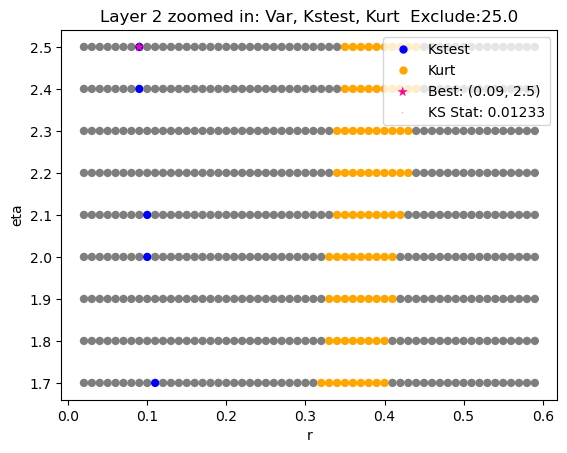

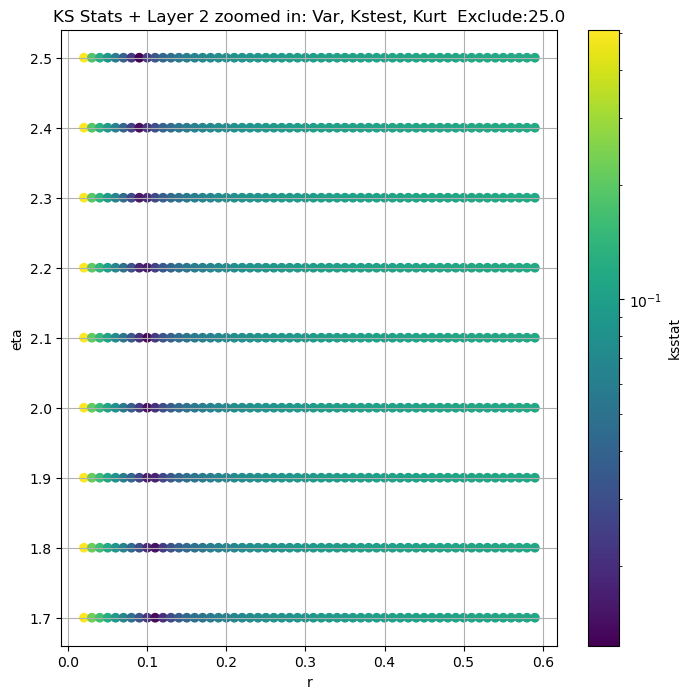

Layer 3


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 100 = 300, ksstat: 0.015127321639645697, var: 7185.1806640625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 75 = 275, ksstat: 0.014314546350527313, var: 7472.93798828125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 50 = 250, ksstat: 0.013305213137219551, var: 7792.3623046875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 25 = 225, ksstat: 0.012195077861196002, var: 8143.22216796875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 0 = 200, ksstat: 0.01114534877370943, var: 8534.3759765625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -25 = 175, ksstat: 0.01106352908674002, var: 8979.40625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -50 = 150, ksstat: 0.011432683603837784, var: 9495.1650390625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -75 = 125, ksstat: 0.011483803705299889, var: 10115.587890625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -100 = 100, ksstat: 0.012708858235736642, var: 10862.390625
Number of samples: 36000, Without approximation : 36000


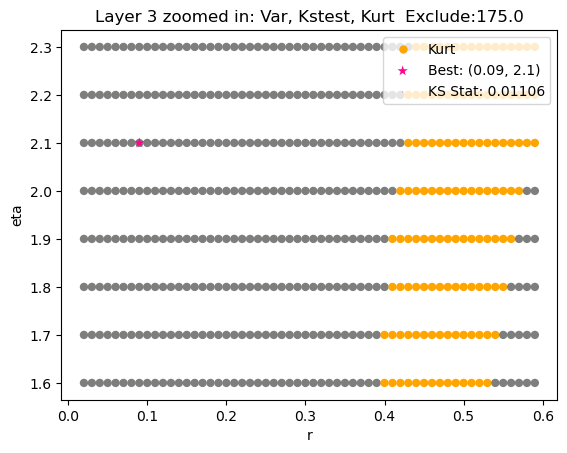

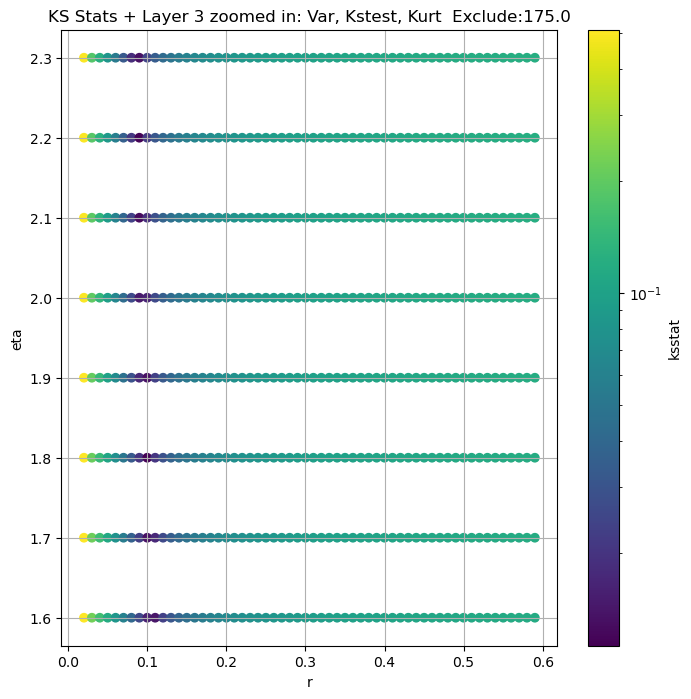

Layer 4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 100 = 600, ksstat: 0.010089819233258145, var: 1598.77978515625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 75 = 575, ksstat: 0.009722359501559232, var: 1631.0218505859375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 50 = 550, ksstat: 0.009450805787203885, var: 1664.98486328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 25 = 525, ksstat: 0.009127984663441231, var: 1700.7447509765625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 0 = 500, ksstat: 0.008718165446577029, var: 1738.3785400390625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -25 = 475, ksstat: 0.008467286450308094, var: 1778.0660400390625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -50 = 450, ksstat: 0.007986900205300105, var: 1820.0439453125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -75 = 425, ksstat: 0.007760828965098946, var: 1864.9503173828125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -100 = 400, ksstat: 0.008014402578627622, var: 1913.54736328125
Number of samples: 100000, Without approximation : 144000


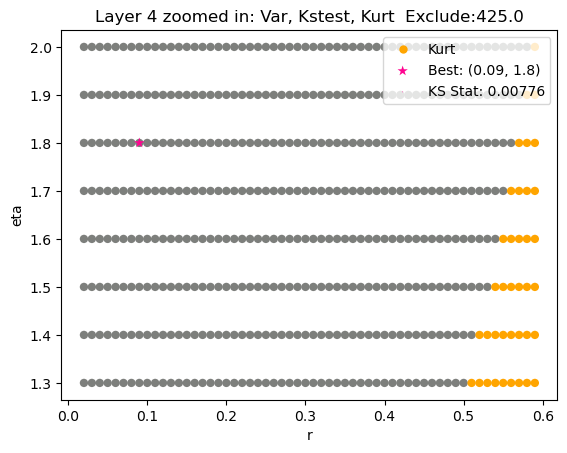

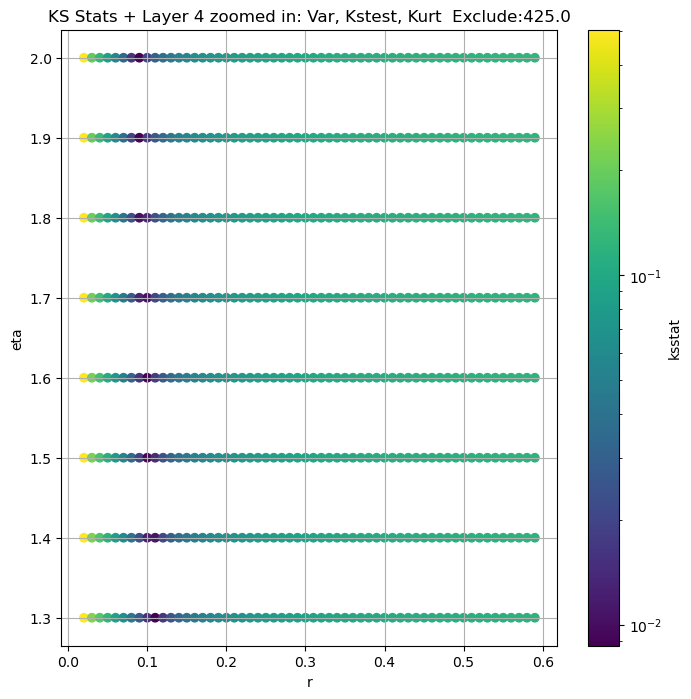

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.007532018026829679, var: 323.3568115234375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.007269548707240614, var: 331.1431579589844


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.007042922041511024, var: 339.471923828125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.007922807771908402, var: 348.485595703125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.00781791431589729, var: 358.29534912109375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.007855013876323147, var: 368.9869079589844


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.008926328233211989, var: 380.6728515625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.009611307935205038, var: 393.46820068359375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.010350264905896578, var: 407.61639404296875
Number of samples: 100000, Without approximation : 576000


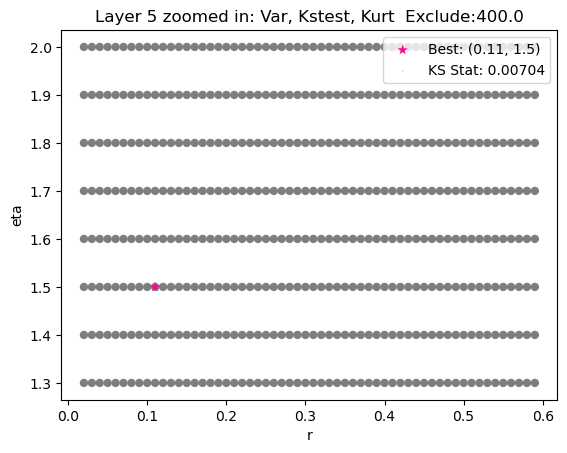

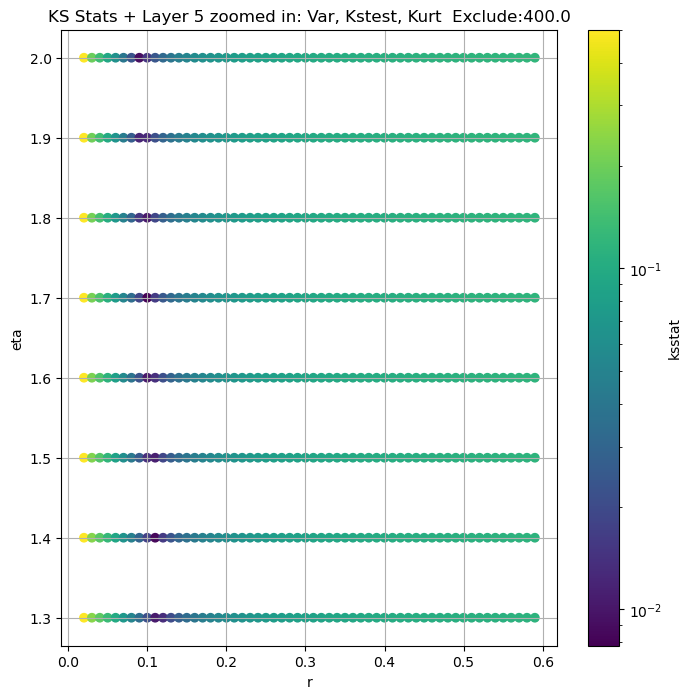

Layer 6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 100 = 400, ksstat: 0.00597916855735503, var: 70.35144805908203


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 75 = 375, ksstat: 0.005678270057439927, var: 71.9931411743164


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 50 = 350, ksstat: 0.005420890892775754, var: 73.77118682861328


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 25 = 325, ksstat: 0.005112321692668731, var: 75.70276641845703


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + 0 = 300, ksstat: 0.005392103284187044, var: 77.81513214111328


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + -25 = 275, ksstat: 0.0062140327443998, var: 80.1507568359375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + -50 = 250, ksstat: 0.006739157572147214, var: 82.75826263427734


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + -75 = 225, ksstat: 0.007315041077613715, var: 85.68809509277344


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 300.0 + -100 = 200, ksstat: 0.008643683479232833, var: 89.02117156982422
Number of samples: 100000, Without approximation : 2304000


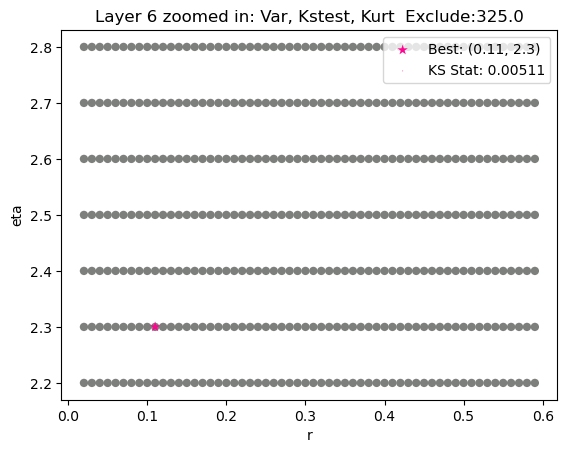

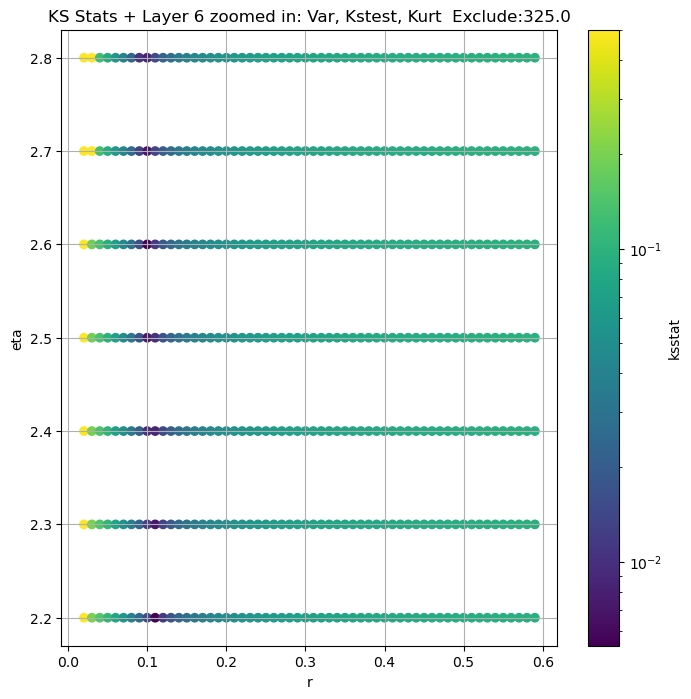

Layer 7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 100 = 350, ksstat: 0.0049749732395095725, var: 19.480979919433594


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 75 = 325, ksstat: 0.004663874889581754, var: 19.87763023376465


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 50 = 300, ksstat: 0.0043475881217435175, var: 20.312122344970703


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 25 = 275, ksstat: 0.004038741996450157, var: 20.791484832763672


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + 0 = 250, ksstat: 0.0037430957850161928, var: 21.324377059936523


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + -25 = 225, ksstat: 0.00345514819151993, var: 21.924209594726562


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + -50 = 200, ksstat: 0.0032093032109368202, var: 22.607736587524414


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + -75 = 175, ksstat: 0.004039009399205984, var: 23.400592803955078


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 250.0 + -100 = 150, ksstat: 0.005124102878203529, var: 24.34249496459961
Number of samples: 100000, Without approximation : 9216000


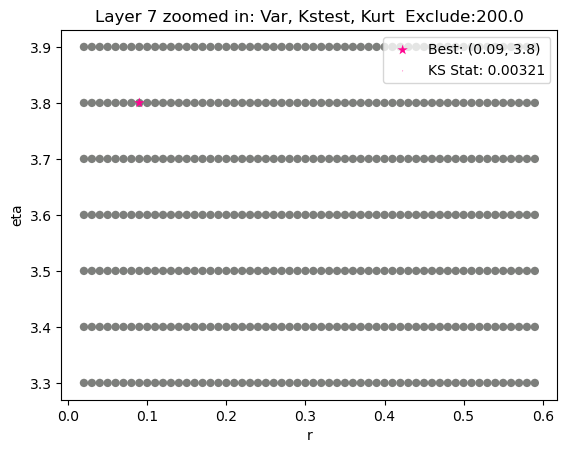

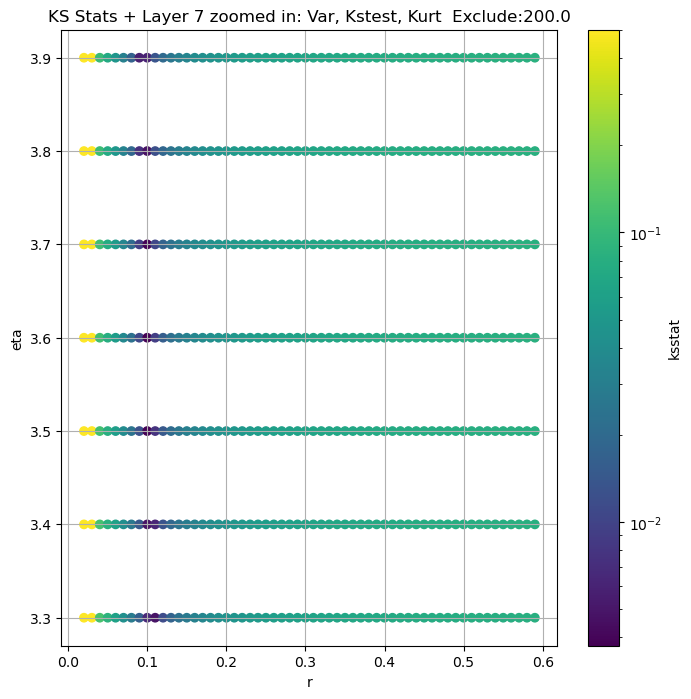

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.004175936105545119, var: 9.357824325561523


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.0036461694095578645, var: 9.581013679504395


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.003146533728290546, var: 9.835453033447266


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.002626668160926271, var: 10.132171630859375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.002190433074926279, var: 10.488604545593262


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.002286299808555381, var: 10.935571670532227


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.003199246535413147, var: 11.52817153930664


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.004643269144505857, var: 12.37867259979248


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.006920028838645009, var: 13.734270095825195
Number of samples: 100000, Without approximation : 36864000


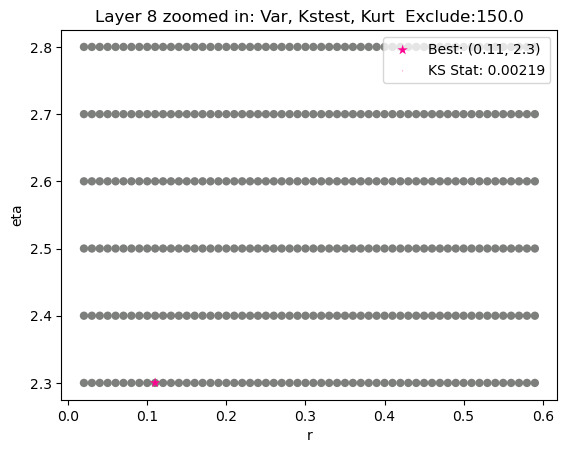

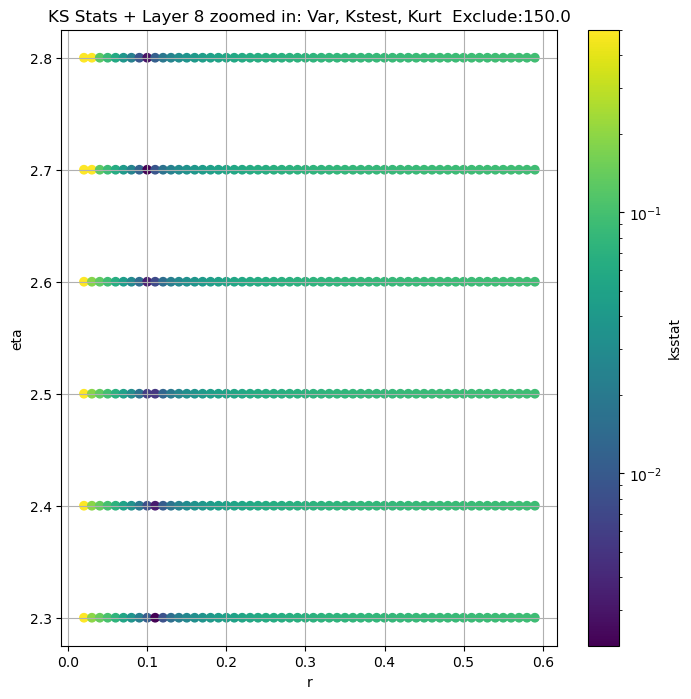

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.005552487207145962, var: 2.6915204524993896


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.005105225671811788, var: 2.753035545349121


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.004703142582816698, var: 2.820767879486084


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.004230766411987887, var: 2.8962578773498535


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.0038092322898495012, var: 2.981694221496582


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.003791290035952688, var: 3.08034610748291


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.004697085275432028, var: 3.19726300239563


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.006130410703468203, var: 3.3411526679992676


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.006394130960493391, var: 3.5275306701660156
Number of samples: 100000, Without approximation : 147456000


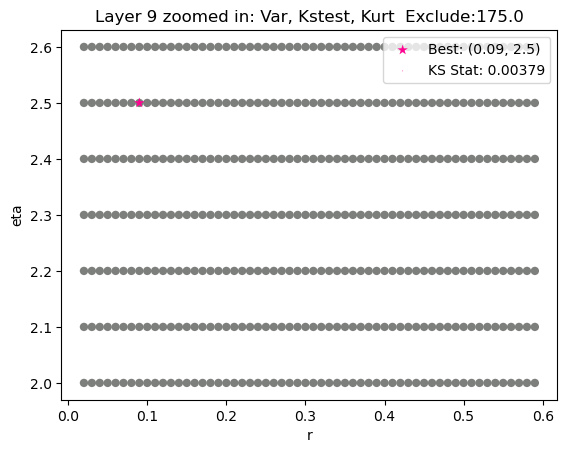

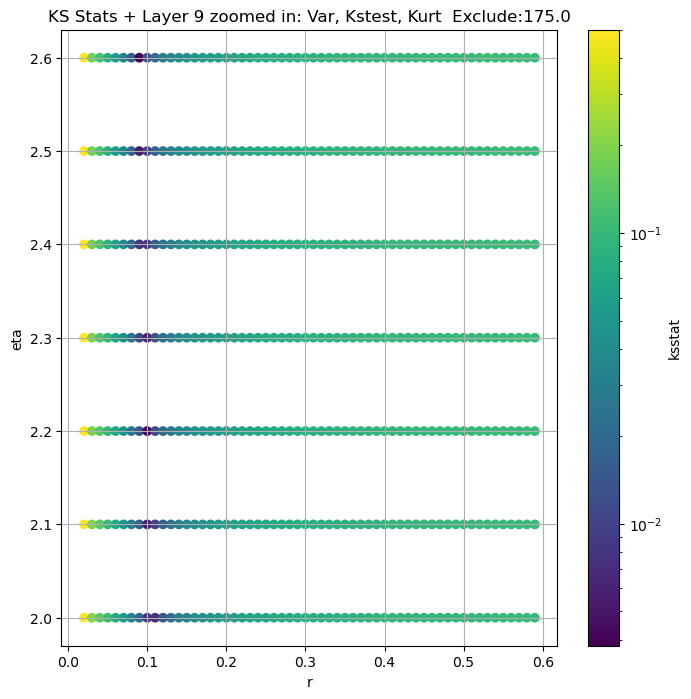

Layer 10


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + 100 = 350, ksstat: 0.006559724910987885, var: 0.3729821741580963


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + 75 = 325, ksstat: 0.006124984038688219, var: 0.3810509741306305


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + 50 = 300, ksstat: 0.00576062651545739, var: 0.3897987902164459


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + 25 = 275, ksstat: 0.005323936419000308, var: 0.3993545472621918


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + 0 = 250, ksstat: 0.004983607146792912, var: 0.4098893702030182


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + -25 = 225, ksstat: 0.004943472711171404, var: 0.4216398298740387


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + -50 = 200, ksstat: 0.005377906486049966, var: 0.43493586778640747


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + -75 = 175, ksstat: 0.006010422364074258, var: 0.45026662945747375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 250.0 + -100 = 150, ksstat: 0.006912825464184813, var: 0.4683845341205597
Number of samples: 100000, Without approximation : 589824000


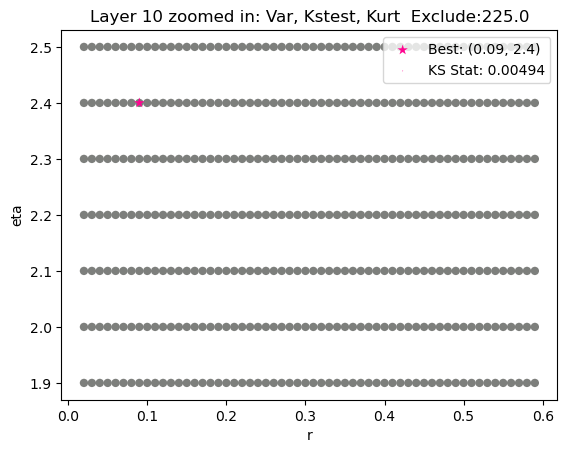

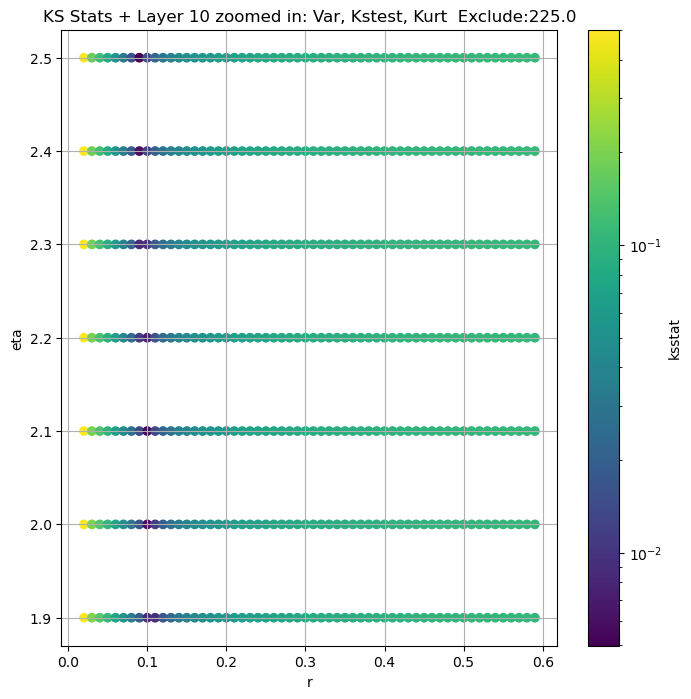

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      150198.140000  85009.770000  248359.050000   411.54047   85.167190   
3       33515.440000  19958.848000   52689.242000   366.28464  101.323944   
4        8690.679000   4650.463400   15441.654000   584.81180  124.459560   
5        1600.978300    772.027800    3722.795000  1309.71000   95.391490   
6         339.471440    152.138280    1059.495200  2686.09840   93.139860   
7          87.097680     35.839172     371.944120  4825.42970   72.401490   
8          29.885605     15.551421      79.539055  1686.66770   80.563995   
9           8.939856      4.773542      23.292429  1590.28990   83.618610   
10          1.352918      0.687688       4.300090  2542.24950   78.125960   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       581.20276           9000             0.012911        0.1          2.1   
3       561.97730          36000             0.011234        0.1          1.8   
4      1337.51990         144000             0.008803        0.1          1.6   
5      3193.55200         576000             0.007818        0.1          1.7   
6      4761.97360        2304000             0.005392        0.1          2.6   
7      6356.89800        9216000             0.003743        0.1          3.5   
8      3720.50220       36864000             0.002191        0.1          2.7   
9      3577.24000      147456000             0.003809        0.1          2.2   
10     4648.80300      589824000             0.005432        0.1          2.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.237964e-12                    25.0        49061.003906   
3       1.598326e-12                   200.0         8979.406250   
4       5.651443e-13                   500.0         1864.950317   
5       8.807122e-14                   350.0          339.471924   
6       2.087537e-15                   300.0           75.702766   
7       9.353144e-17                   250.0           22.607737   
8       2.262047e-16                   150.0           10.488605   
9       2.015712e-16                   200.0            3.080346   
10      3.540686e-17                   250.0            0.421640   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.012329    0.09       2.5   
3                     0.007153          0.011064    0.09       2.1   
4                     0.003578          0.007761    0.09       1.8   
5                     0.001789          0.007043    0.11       1.5   
6                     0.000895          0.005112    0.11       2.3   
7                     0.000447          0.003209    0.09       3.8   
8                     0.000224          0.002190    0.11       2.3   
9                     0.000112          0.003791    0.09       2.5   
10                    0.000056          0.004943    0.09       2.4   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      7.445190e-15                 25.0        12811  
3      3.894479e-15                175.0        15187  
4      1.908989e-15                425.0        30375  
5      8.839586e-12                400.0        36000  
6      2.921299e-13                325.0        72000  
7      1.976134e-19                200.0       182250  
8      4.047455e-14                150.0       389236  
9      4.674540e-19                175.0       129742  
10     8.243315e-20                225.0        72000

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

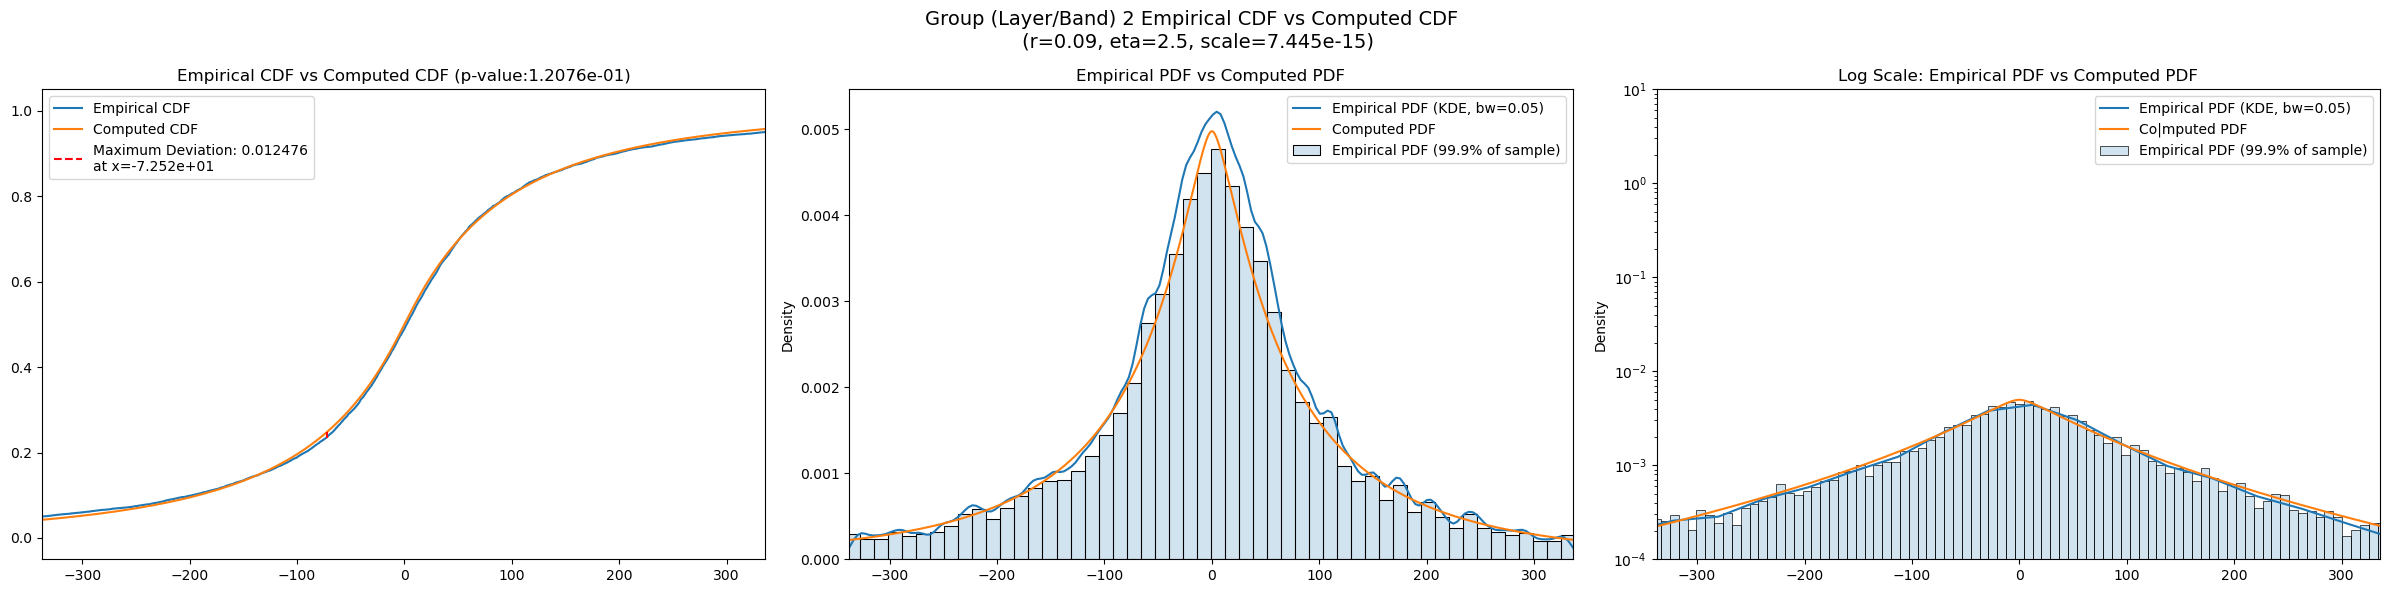

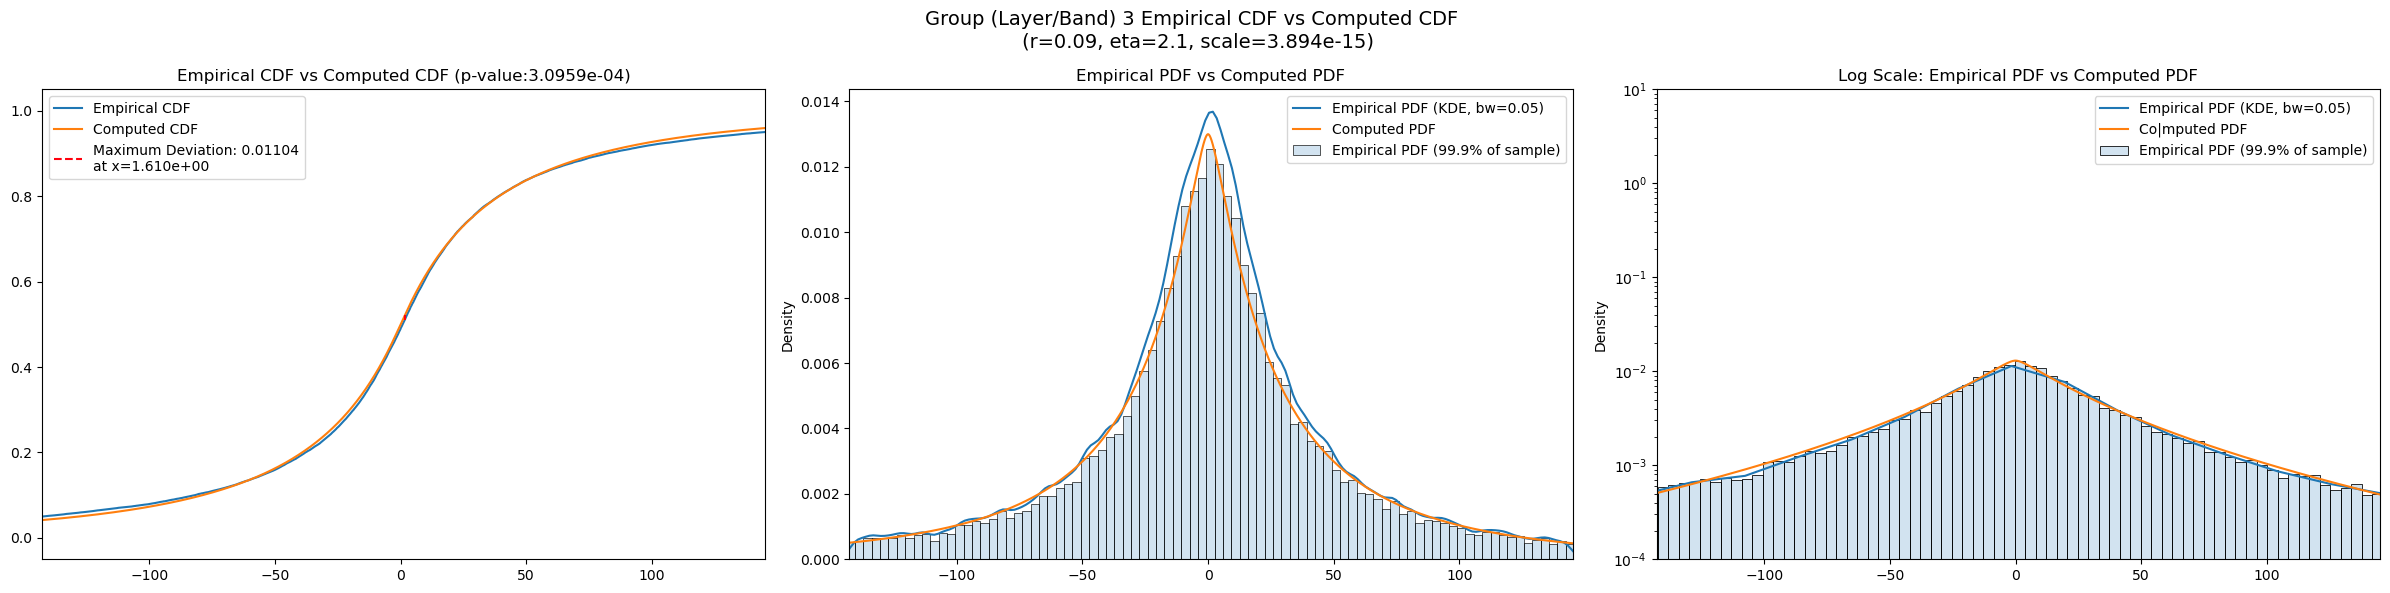

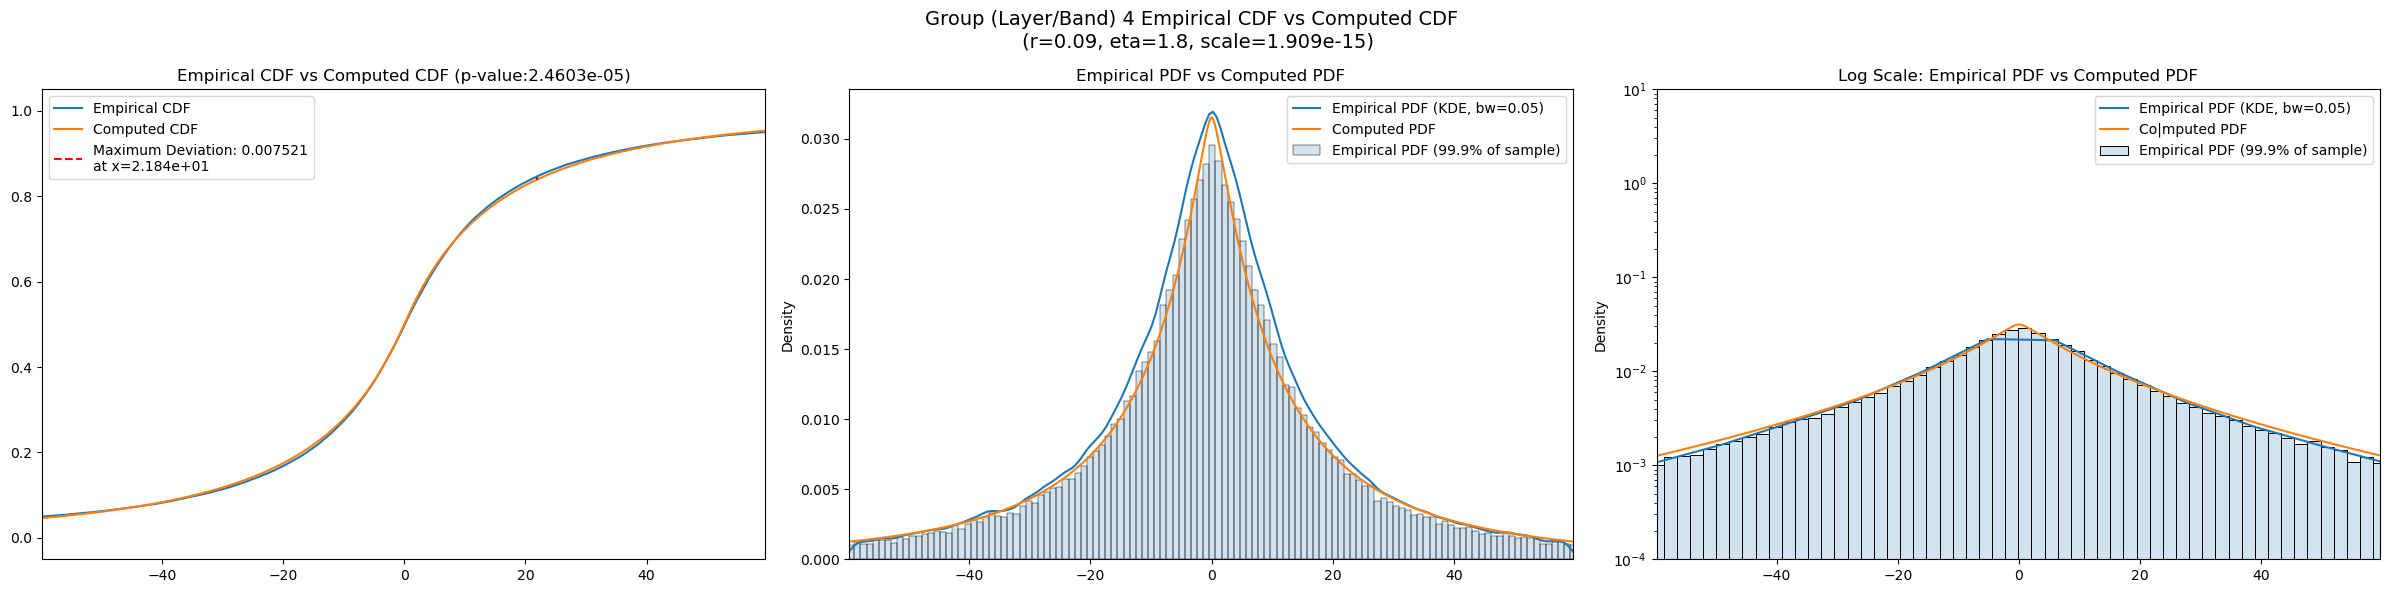

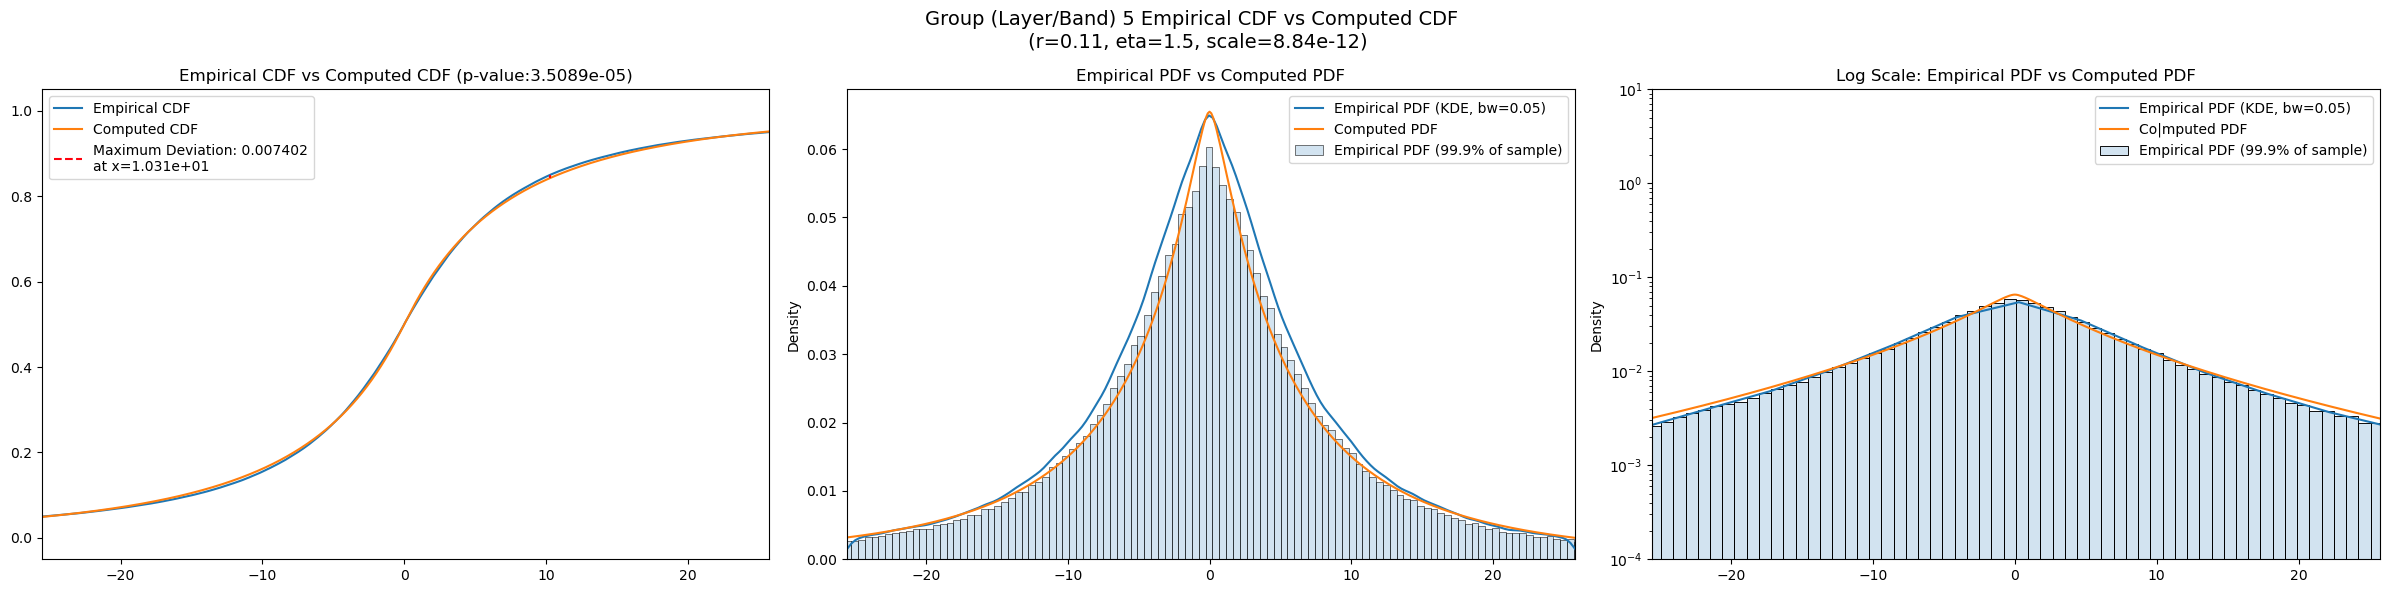

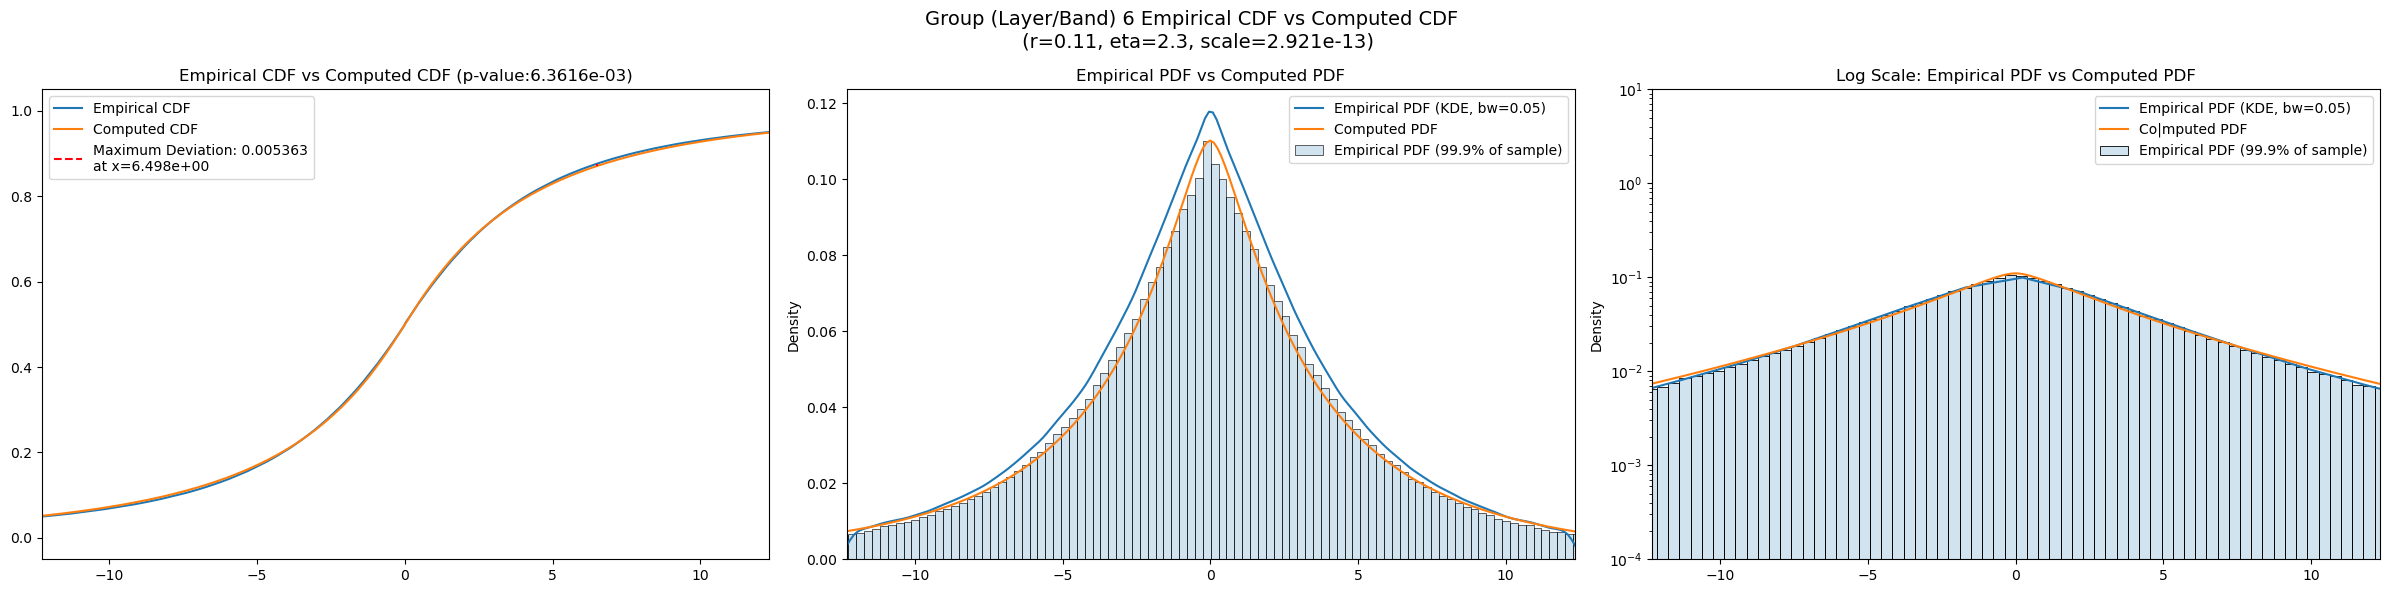

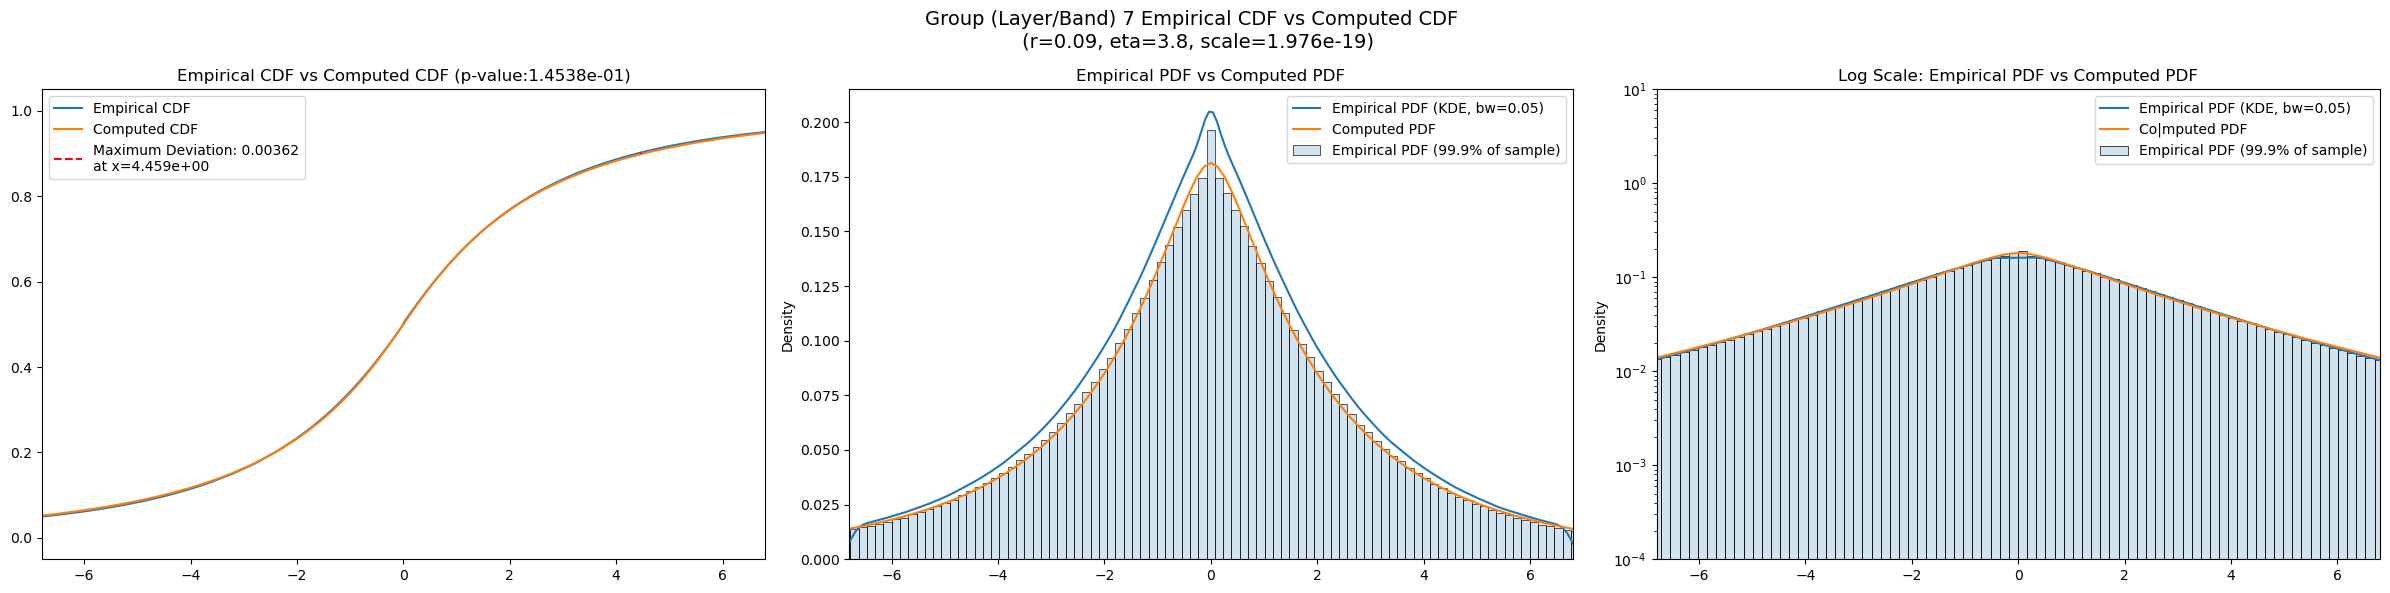

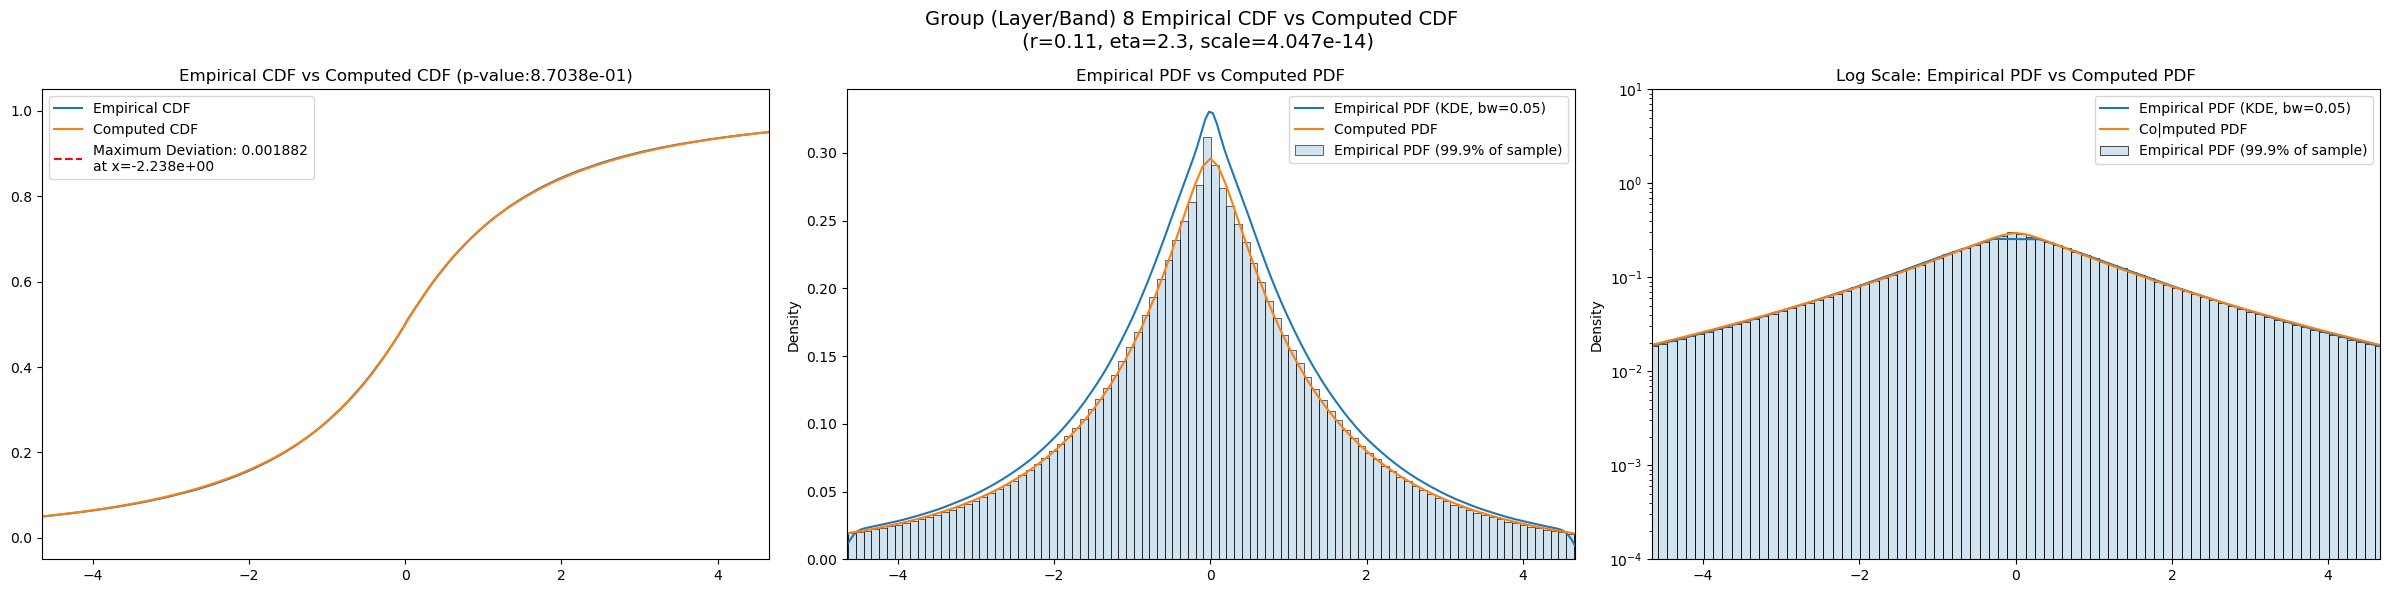

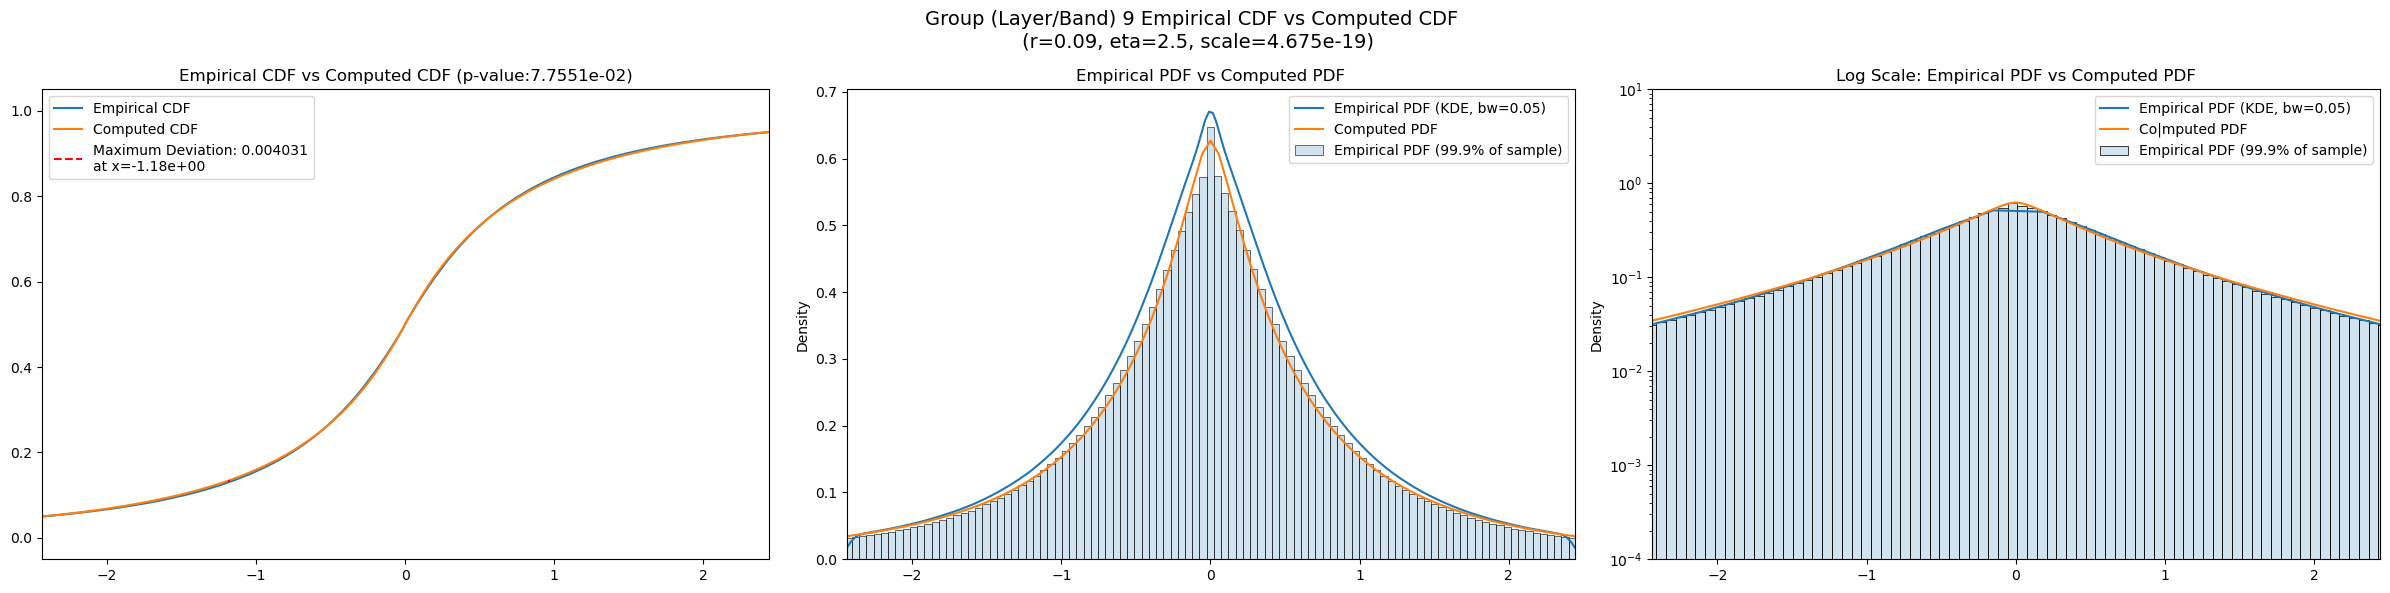

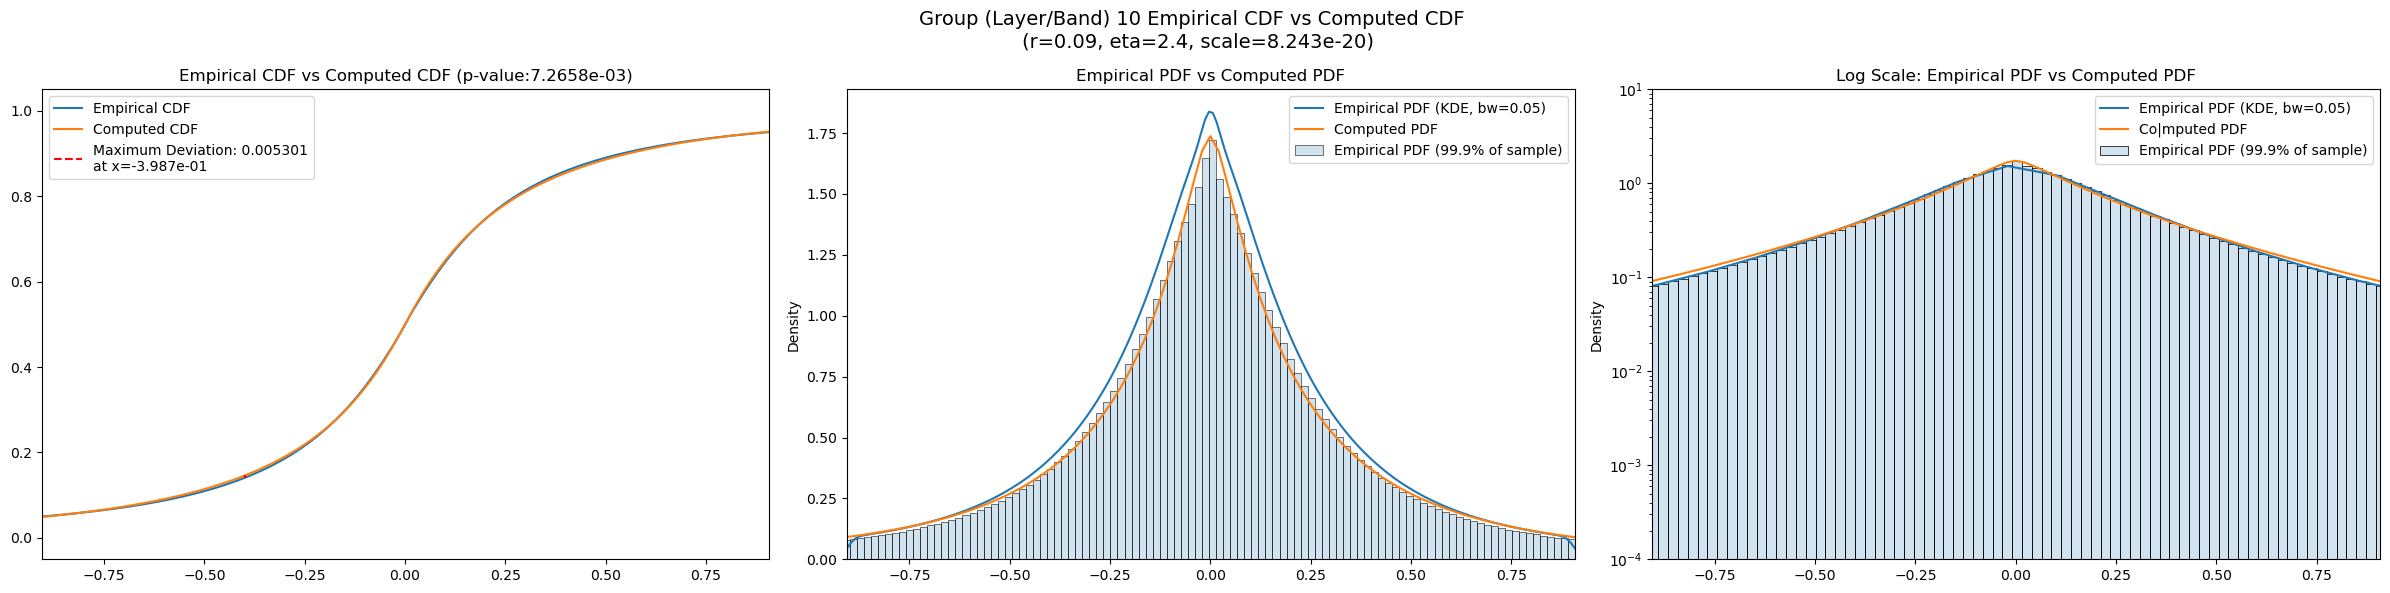

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      150198.140000  85009.770000  248359.050000   411.54047   85.167190   
3       33515.440000  19958.848000   52689.242000   366.28464  101.323944   
4        8690.679000   4650.463400   15441.654000   584.81180  124.459560   
5        1600.978300    772.027800    3722.795000  1309.71000   95.391490   
6         339.471440    152.138280    1059.495200  2686.09840   93.139860   
7          87.097680     35.839172     371.944120  4825.42970   72.401490   
8          29.885605     15.551421      79.539055  1686.66770   80.563995   
9           8.939856      4.773542      23.292429  1590.28990   83.618610   
10          1.352918      0.687688       4.300090  2542.24950   78.125960   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       581.20276           9000             0.012911        0.1          2.1   
3       561.97730          36000             0.011234        0.1          1.8   
4      1337.51990         144000             0.008803        0.1          1.6   
5      3193.55200         576000             0.007818        0.1          1.7   
6      4761.97360        2304000             0.005392        0.1          2.6   
7      6356.89800        9216000             0.003743        0.1          3.5   
8      3720.50220       36864000             0.002191        0.1          2.7   
9      3577.24000      147456000             0.003809        0.1          2.2   
10     4648.80300      589824000             0.005432        0.1          2.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      126.385000              0.053258          1.255430e-22   
3      ...       51.101700              0.057059         2.548010e-102   
4      ...       21.929000              0.052133          0.000000e+00   
5      ...       10.280800              0.046284          0.000000e+00   
6      ...        5.463860              0.038779          0.000000e+00   
7      ...        3.122860              0.035896          0.000000e+00   
8      ...        2.034530              0.040485          0.000000e+00   
9      ...        1.019910              0.043481          0.000000e+00   
10     ...        0.371222              0.044814          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         112.080000             0.027645         2.079440e-06  88.336000   
3          45.223400             0.030597         1.028020e-29  35.564800   
4          19.617600             0.027256         2.299990e-93  15.329100   
5           9.169000             0.022132        1.610800e-245   7.235440   
6           4.855680             0.015040         0.000000e+00   3.837990   
7           2.768360             0.011099         0.000000e+00   2.214910   
8           1.797300             0.014289         0.000000e+00   1.433320   
9           0.905582             0.018277         0.000000e+00   0.715672   
10          0.330311             0.020042         0.000000e+00   0.260216   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.024453   4.158910e-05          1.285468e-01  
3           0.028188   2.779550e-25          2.953543e-04  
4           0.022673   9.738230e-65          5.824506e-08  
5           0.015881  1.280120e-126          3.034669e-25  
6           0.009454  2.743290e-179          9.902923e-53  
7           0.009042   0.000000e+00          7.119544e-83  
8           0.012340   0.000000e+00         4.678906e-154  
9           0.014054   0.000000e+00          0.000000e+00  
10        

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.012911                 0.014297          0.012329   
3                 0.011234                 0.007153          0.011064   
4                 0.008803                 0.003578          0.007761   
5                 0.007818                 0.001789          0.007043   
6                 0.005392                 0.000895          0.005112   
7                 0.003743                 0.000447          0.003209   
8                 0.002191                 0.000224          0.002190   
9                 0.003809                 0.000112          0.003791   
10                0.005432                 0.000056          0.004943   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.053258             0.027645       0.024453  
3                  0.057059             0.030597       0.028188  
4                  0.052133             0.027256       0.022673  
5                  0.046284             0.022132       0.015881  
6                  0.038779             0.015040       0.009454  
7                  0.035896             0.011099       0.009042  
8                  0.040485             0.014289       0.012340  
9                  0.043481             0.018277       0.014054  
10                 0.044814             0.020042       0.015006

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            49061.003906          0.012329    0.09       2.5  7.445190e-15   
3             8979.406250          0.011064    0.09       2.1  3.894479e-15   
4             1864.950317          0.007761    0.09       1.8  1.908989e-15   
5              339.471924          0.007043    0.11       1.5  8.839586e-12   
6               75.702766          0.005112    0.11       2.3  2.921299e-13   
7               22.607737          0.003209    0.09       3.8  1.976134e-19   
8               10.488605          0.002190    0.11       2.3  4.047455e-14   
9                3.080346          0.003791    0.09       2.5  4.674540e-19   
10               0.421640          0.004943    0.09       2.4  8.243315e-20   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                    175.0  
4                    425.0  
5                    400.0  
6                    325.0  
7                    200.0  
8                    150.0  
9                    175.0  
10                   225.0

In [21]:
eng.quit()